# AB Teste Course - PA James

## 0.1. Imports

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.stats import api as sms
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_1samp, shapiro, ttest_ind, mannwhitneyu, f_oneway


## 1.0. Load Data

In [2]:

df_raw = pd.read_csv("../datasets/ab_data.csv")

In [3]:
df_raw

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


## 2.0. Design de Experimentos

### 2.1. Formulação das hipoteses

### 2.2. Parâmetros do Experimento

In [4]:
# nivel de confiança
confidence_level = 0.95

# nivel de significancia
significanse_level = 1 - confidence_level

# conversóes da página atual e da nova pagina
p1 = 0.13
p2 = 0.15

# tamanho do efeito
effect_size = sms.proportion_effectsize(p1, p2)

# Poder estatístico
power = 0.80

# sample size
sample_n = sms.NormalIndPower().solve_power(
                effect_size,
                power=power,
                alpha=significanse_level

)

sample_n = math.ceil(sample_n)
sample_n

4720

In [5]:
conversion_rate = 0.10
x = sample_n / conversion_rate
print("O numero de email para enviar: {}".format(int(x)))
print("O numero total da base de email para enviar: {}".format(int(2*x)))

O numero de email para enviar: 47200
O numero total da base de email para enviar: 94400


In [6]:
print("O tamanho total da amostra é de {}".format( 2*sample_n))
print("O tamanho da amostra do grupo controle é de: {}".format( sample_n))
print("O tamanho da amostra do grupo tratamento é de: {}".format( sample_n))

O tamanho total da amostra é de 9440
O tamanho da amostra do grupo controle é de: 4720
O tamanho da amostra do grupo tratamento é de: 4720


In [7]:
## Anásise descritiva dos dados
print(f"Number of rows: {df_raw.shape[0]}")
print(f"Number of cols: {df_raw.shape[1]}")


Number of rows: 294478
Number of cols: 5


In [8]:
# Verificar dados faltantes
df_raw.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
#3.2 Conferir as flags do teste A
df_user_delete = df_raw[['user_id', 'group']].groupby('user_id').count().reset_index().query('group > 1')['user_id']
df1 = df_raw[~df_raw['user_id'].isin(df_user_delete)]
df1.shape

(286690, 5)

In [10]:
#data without duplicated
df1[['user_id','group', 'landing_page']].groupby(['group', 'landing_page']).count().reset_index()

,group,landing_page,user_id
0,control,old_page,143293
1,treatment,new_page,143397


In [11]:
# 3.3 Amostragem aleatória dos grupos Controle e Tratamento
# Control group
df_control_sample = df1[df1['group'] == 'control'].sample(n=sample_n, random_state=42)
print(f'Size of Control group: {df_control_sample.shape[0]}')

# Treatment group
df_treatment_sample = df1[df1['group'] == 'treatment'].sample(n=sample_n, random_state=42)
print(f'Size of tratment group: {df_treatment_sample.shape[0]}')

# Total Sample Size
df_ab = pd.concat([df_control_sample, df_treatment_sample]).reset_index(drop=True)
print(f'Total sample size: {df_ab.shape[0]}')


Size of Control group: 4720
Size of tratment group: 4720
Total sample size: 9440


In [12]:
#Cálculo da métrica de interesse entre os groupos (Conversão de cada página)

#Control Group
sales = df_control_sample.loc[df_control_sample['converted'] == 1, 'converted'].sum()
visit = len(df_control_sample)

conversion_rate_control = sales / visit
print(f'Converstion Rate - Control Goup: {conversion_rate_control:.4f}')

#Treatment Group
sales = df_treatment_sample.loc[df_treatment_sample['converted'] == 1, 'converted'].sum()
visit = len(df_treatment_sample)

conversion_rate_treatment = sales / visit
print(f'Converstion Rate - treatment Goup: {conversion_rate_treatment:.4f}')


# conversão = compradores / visitantes


Converstion Rate - Control Goup: 0.1155
Converstion Rate - treatment Goup: 0.1290


# 3.0 Testes Estatísticos

## 3.1 One-Sample Test

In [13]:
df = [14, 14, 16, 13, 12, 17, 15, 14, 15, 13, 15, 14]

# H0: u = 15 (Altura média das espécies das plantas de fato é 15cm )
# H1: <> = 15 (Altura média das espécies das plantas é diferente de é 15cm )


In [14]:
statstic, pvalue = ttest_1samp(df, popmean=15)
print (f'p-values: {pvalue}')

alpha = 0.05
if pvalue < alpha:
    print('Rejeita a hiptese nula')
else:
    print('Falha em rejeitar a hipótise nula (Assumi a hipótese nula)')

# Se p-value for < alpha rejeita-se H0
#   Ou sejá, a altura media das plantas é diferente de 15 cm

# Se p-value for > alpha rejeita-se H0
#   Ou sejá, as plantas podem ter em media 15 cm

p-values: 0.12014460742498101
Falha em rejeitar a hipótise nula (Assumi a hipótese nula)


## 3.2 Two-Sample Test (Condições Paramétricas são satisfeitas)

In [15]:
df1 = np.array([14, 15, 15, 16, 13, 8, 14, 17, 16, 14, 19, 20, 21, 15, 15, 16, 16, 13, 14, 12])
df2 = np.array([15, 17, 14, 17, 14, 8, 12, 19, 19, 14, 17, 22, 24, 16, 13, 16, 13, 18, 15, 13])


# H0: u1 = u2 (Altura média das espécies dos grupos de plantas são iguais )
# H1: <> = 15 (Altura média das espécies dos grupos de plantas são diferente)

print (np.mean(df1))
print (np.mean(df2))



15.15
15.8


In [16]:
# Condições paramétricas

# 1. Amostras Indepedents
# 2. Normamente distrinuídos

## Teste de Normalidade - Shapiro
# H0: Distribuição não normal
# H1: Distribuição normalmente distribuido

# if pvalue < alpha
#  print ('Rejeito a hipótese nula')
#  pvalue = 0.0001 - Digo que não é normal
#
# else
#  print('Falha em rejeitar a hipótese nula')
#  pvalue = 0.89392 - é normal
#
stats1, pvalue1 = shapiro(df1)
print(f'p-value1: {pvalue1}')

stats2, pvalue2 = shapiro(df2)
print(f'p-value2: {pvalue2}')


# 3. Variancias iguais
print(f'\nVar 1: {np.var(df1)}')
print(f'Var 2: {np.var(df2)}')


stats, pvalue = ttest_ind(df1, df2, equal_var=True)
print(f'p-value: {pvalue}')

alpha = 0.05
if pvalue < alpha:
    print('Rejeita a hipótese nula')

else:
    print('Falha em rejeitar a hipótese nula')
    


p-value1: 0.2267739325761795
p-value2: 0.6782065033912659

Var 1: 7.727500000000001
Var 2: 12.260000000000002
p-value: 0.5300471010405257
Falha em rejeitar a hipótese nula


## 3.3 Mann-Whitney U-test (Condições Paramétricas são satisfeitas)

In [17]:
df1 = [20, 23, 21, 20, 18, 17, 18, 14, 20, 24, 43, 19]
df2 = [24, 25, 21, 22, 23, 18, 17, 28, 24, 27, 21, 23]

In [18]:
np.mean(df1)

21.416666666666668

In [19]:
np.mean(df2)

22.75

In [20]:
# H0: u1 = u2 (Altura média das plantas dos grupos são iguais )
# H1: <> = 15 (Altura média das plantas dos grupos não são diferente)

In [21]:
# Condições paramétricas

# 1. Amostras Indepedents
# 2. Normamente distrinuídos

## Teste de Normalidade - Shapiro
# H0: Distribuição não normal
# H1: Distribuição normalmente distribuido

# if pvalue < alpha
#  print ('Rejeito a hipótese nula')
#  pvalue = 0.0001 - Digo que não é normal
#
# else
#  print('Falha em rejeitar a hipótese nula')
#  pvalue = 0.89392 - é normal
#
stats1, pvalue1 = shapiro(df1)
print(f'p-value1: {pvalue1}')

stats2, pvalue2 = shapiro(df2)
print(f'p-value2: {pvalue2}')


# 3. Variancias iguais
print(f'\nVar 1: {np.var(df1)}')
print(f'Var 2: {np.var(df2)}')


stats, pvalue = mannwhitneyu(df1, df2)
print(f'p-value: {pvalue}')

alpha = 0.05
if pvalue < alpha:
    print('Rejeita a hipótese nula')

else:
    print('Falha em rejeitar a hipótese nula')
    


p-value1: 0.0005459139938466251
p-value2: 0.9021514058113098

Var 1: 48.743055555555564
Var 2: 9.6875
p-value: 0.07217495133598324
Falha em rejeitar a hipótese nula


## 3.4 Anova

In [22]:
df = pd.DataFrame({'A': [25, 30, 28, 36, 29],
                   'B': [45, 55, 29, 56, 40],
                   'C': [30, 29, 33, 37, 27],
                   'D': [54, 60, 51, 62, 73]})

In [23]:
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['A', 'B', 'C', 'D'])
df_melt.columns = ['index', 'treatment', 'value']
df_melt.head()

,index,treatment,value
0,0,A,25
1,1,A,30
2,2,A,28
3,3,A,36
4,4,A,29


<Axes: xlabel='treatment', ylabel='value'>

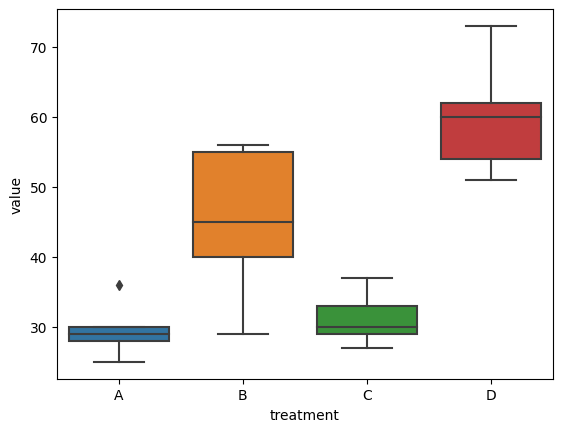

In [24]:
sns.boxplot(x='treatment', y='value', data=df_melt)

In [25]:
print(f'pvalue - Grupo A: {shapiro(df["A"])}')
print(f'pvalue - Grupo B: {shapiro(df["B"])}')
print(f'pvalue - Grupo C: {shapiro(df["C"])}')
print(f'pvalue - Grupo D: {shapiro(df["D"])}')

print(f'\nVariance - Grupo A: {np.var(df["A"])}')
print(f'Variance - Grupo B: {np.var(df["B"])}')
print(f'Variance - Grupo C: {np.var(df["C"])}')
print(f'Variance - Grupo D: {np.var(df["D"])}')

pvalue - Grupo A: ShapiroResult(statistic=0.9316344261169434, pvalue=0.6075581908226013)
pvalue - Grupo B: ShapiroResult(statistic=0.9264495968818665, pvalue=0.5723677277565002)
pvalue - Grupo C: ShapiroResult(statistic=0.9529604315757751, pvalue=0.7583119869232178)
pvalue - Grupo D: ShapiroResult(statistic=0.9448273181915283, pvalue=0.7002365589141846)

Variance - Grupo A: 13.040000000000001
Variance - Grupo B: 100.4
Variance - Grupo C: 12.16
Variance - Grupo D: 58.0


In [26]:
stats, pvalue = f_oneway(df['A'], df['B'], df['C'], df['D'])
print(f'pvalue: {pvalue}')


# H0: Não há diferença na altura média
# H1: Há diferença na altura média

alpha = 0.05

if pvalue < alpha:
    print('Rejeita a hipótese nula')
else:
    print('Falha em rejeita a hipotese nula - Aceita a H0')

pvalue: 2.639241146210922e-05
Rejeita a hipótese nula


In [27]:
tukey = pairwise_tukeyhsd(endog=df_melt['value'], 
                          groups=df_melt['treatment'],
                          alpha=0.05)
print(tukey)


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B     15.4 0.0251   1.694 29.106   True
     A      C      1.6 0.9867 -12.106 15.306  False
     A      D     30.4 0.0001  16.694 44.106   True
     B      C    -13.8 0.0482 -27.506 -0.094   True
     B      D     15.0 0.0296   1.294 28.706   True
     C      D     28.8 0.0001  15.094 42.506   True
---------------------------------------------------
